In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


### Importing Libraries and Data

In [26]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [27]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating

from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.layers import SpatialDropout1D, Dropout  # drop out layers

In [29]:
train_file = 'train.csv'
train_df = pd.read_csv(train_file)
train_df.head()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0


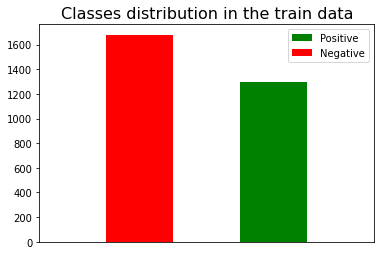

In [30]:
plt.hist(train_df[train_df.label == 1].label,
         bins=2, color='green', label='Positive')
plt.hist(train_df[train_df.label == 0].label,
         bins=2, color='red', label='Negative')
plt.title('Classes distribution in the train data', fontsize=16)
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [31]:
# checking if any row has null values
print(train_df.isnull().sum())

text      0
aspect    0
label     0
dtype: int64


### Pre-processing the data

In [32]:
#keeping just the english alphabets for further processing
def tokens(words):
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                 
    return " ".join(text)  

train_df["clear_text"] = train_df['text'].apply(tokens)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,can you check whether its cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely on both milk delivery and grocery ...
2,"I get no notification, however the app is real...",notification,0,i get no notification however the app is reall...
3,"Love this app, but would love it even more if ...",view,1,love this app but would love it even more if g...
4,it does not let me load a clip on the scene,load,0,it does not let me load a clip on the scene


In [33]:
# removing the very common words which doesn't helps the model
stop_words = stopwords.words('english') + list(string.punctuation)
def stopwords(review):
    text = [word.lower() for word in review.split() if word.lower() not in stop_words]
    return " ".join(text)

train_df['clear_text'] = train_df['clear_text'].apply(stopwords)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery items
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt charts calendar...
4,it does not let me load a clip on the scene,load,0,let load clip scene


In [34]:
# The next step is the normalization of words in the corpus by transform all of different forms of the word into one. 
# The two methods that exist for this purpose are Stemming and Lemmatization. We used the Lemmatization one.
lem = WordNetLemmatizer()

def lemma(text):
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)

train_df['clear_text'] = train_df['clear_text'].apply(lemma)
train_df.head()

,text,aspect,label,clear_text
0,can you check whether its cancelled completely?,cancelled,1,check whether cancelled completely
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
3,"Love this app, but would love it even more if ...",view,1,love app would love even gantt chart calendar ...
4,it does not let me load a clip on the scene,load,0,let load clip scene


In [35]:
# droping the neutral statements because they don't contribute to out model
train_df = train_df[train_df.label != 1]
train_df.head()

,text,aspect,label,clear_text
1,cannot rely on both milk delivery and grocery ...,Milk,0,cannot rely milk delivery grocery item
2,"I get no notification, however the app is real...",notification,0,get notification however app really fine
4,it does not let me load a clip on the scene,load,0,let load clip scene
5,"i love notion as a tool, but the mobile just t...","tool,",2,love notion tool mobile take way long load
7,"some times missing to deliver, some times diff...","deliver,",0,time missing deliver time different order deli...


In [36]:
# seperating the X data
x_data = train_df.drop(['text', 'aspect', 'label'], axis=1)
x_data = x_data.rename(columns={"clear_text":"review"})
x_data.head()

,review
1,cannot rely milk delivery grocery item
2,get notification however app really fine
4,let load clip scene
5,love notion tool mobile take way long load
7,time missing deliver time different order deli...


In [37]:
# seperating the y data
y_data = train_df.drop(['text', 'aspect', 'clear_text'], axis=1)
y_data.head()

,label
1,0
2,0
4,0
5,2
7,0


In [38]:
X = x_data.review
y = y_data.label
print("Training Set X Items: " + str(len(X)))
print("Training Set y Items: " + str(len(y)))

Training Set X Items: 2706
Training Set y Items: 2706


In [39]:
# splitting the data into train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

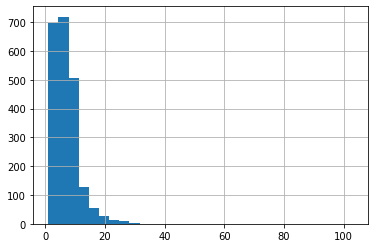

In [40]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)

In [41]:
# creating the vocabulary
y_training = y_train.values
y_validation = y_valid.values

vocab = X_train.values
vocab

array(['notion becoming famous one best apps use especially online class useful',
       'notion quickly become hub personal work project',
       'delivery especially milk', ..., 'download gave blank screen',
       'stopped using io note onenotes go app soon turn ipad',
       'prompt delivery immaterial weather condition'], dtype=object)

In [42]:
# Vectorize a text corpus, by turning each text into sequence of integers

tokenizer = Tokenizer(num_words=3200,oov_token='OOV')
tokenizer.fit_on_texts(vocab)

vocab_size = len(tokenizer.word_index) + 1

print(tokenizer)
print(vocab_size)

2776


In [43]:
# Store and Padding Converted Sequences
review = X_train.values
review_seqs = tokenizer.texts_to_sequences(review)
padded_sequence_train = pad_sequences(review_seqs, maxlen=10, padding='post', truncating='post', value=0)

docs = X_valid.values
docs_seqs = tokenizer.texts_to_sequences(docs)
padded_sequence_valid = pad_sequences(docs_seqs, maxlen=10, padding='post', truncating='post', value=0)

print(padded_sequence_train[0])
print("***************************************************")
print(padded_sequence_valid[0])

[   4 1464  993   16   19   87    9  262  364  745]
***************************************************
[167  20   8 245  62  33   0   0   0   0]


### Making and Training the Model

In [44]:
# creating the model architecture
embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=10) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 32)            88832     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 10, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 105,483
Trainable params: 105,483
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# training the model
history = model.fit(padded_sequence_train, y_training, batch_size=128, epochs=10, verbose=1, validation_data=(padded_sequence_valid, y_validation))

Epoch 1/10
17/17 [==============================] - 4s 47ms/step - loss: 0.6515 - accuracy: 0.0189 - val_loss: 0.5970 - val_accuracy: 0.0000e+00
Epoch 2/10
17/17 [==============================] - 0s 26ms/step - loss: 0.5227 - accuracy: 0.0000e+00 - val_loss: 0.4828 - val_accuracy: 0.0000e+00
Epoch 3/10
17/17 [==============================] - 0s 26ms/step - loss: 0.2954 - accuracy: 0.0065 - val_loss: 0.0261 - val_accuracy: 0.0166
Epoch 4/10
17/17 [==============================] - 0s 25ms/step - loss: -1.0470 - accuracy: 0.2380 - val_loss: -1.0984 - val_accuracy: 0.4022
Epoch 5/10
17/17 [==============================] - 0s 25ms/step - loss: -2.4393 - accuracy: 0.4737 - val_loss: -1.4539 - val_accuracy: 0.4428
Epoch 6/10
17/17 [==============================] - 0s 25ms/step - loss: -3.0642 - accuracy: 0.5005 - val_loss: -1.6877 - val_accuracy: 0.4207
Epoch 7/10
17/17 [==============================] - 0s 27ms/step - loss: -3.9075 - accuracy: 0.5069 - val_loss: -1.9337 - val_accuracy: 

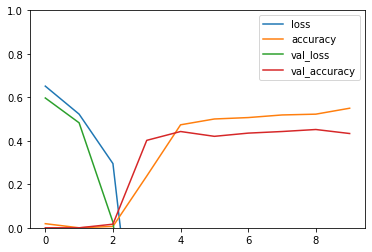

In [46]:
# Performance of the model on training and validation sets
pd.DataFrame(history.history).plot()
plt.gca().set_ylim(0, 1)
plt.show()

### Saving the model

In [47]:
# serialize model to JSON
model_json = model.to_json()
with open("models/rnn_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/rnn_model.h5")
print("Saved model to disk")

Saved model to disk
